In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from skimage.io import imread
from scipy.spatial import KDTree
from skimage.feature import peak_local_max


CHANNELS = ['cy5', 'TxRed', 'cy3', 'FAM']
BASE_DIR = Path('E:/TMC/PRISM_pipeline/dataset/processed')
RUN_ID = '_example_dataset'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
os.makedirs(read_dir, exist_ok=True)


TOPHAT_KERNEL_SIZE = 7
def tophat_spots(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(TOPHAT_KERNEL_SIZE,TOPHAT_KERNEL_SIZE))
    return cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)


def divide_main(func, shape, max_volume=10**9, overlap=500):
    zrange, xrange, yragne = shape
    xy_size =  int(np.sqrt(max_volume / zrange))
    x_num = -(-(xrange - overlap) // (xy_size - overlap))
    y_num = -(-(yragne - overlap) // (xy_size - overlap))
    cut_x = xrange // x_num + overlap
    cut_y = yragne // y_num + overlap
    print(f"n_tile: {x_num * y_num};", f"\nx_slice_num: {x_num};", f"y_slice_num: {y_num};")
    print(f"block_x: {cut_x};", f"block_y: {cut_y};", f"overlap: {overlap};")
    
    pad_x, pad_y = 1, 1
    x_step = cut_x - overlap
    y_step = cut_y - overlap
    with tqdm(total=x_num * y_num, desc='tile') as pbar:
        for x_pos in range(x_num):
            for y_pos in range(y_num):
                func(pad_x, cut_x, pad_y, cut_y, x_pos, y_pos, x_num, y_num, overlap)
                pad_y += y_step
                pbar.update(1)
            pad_x += x_step
            pad_y = 0


def extract_coordinates(image, snr=4, quantile=0.96):
    meta = {}
    coordinates = peak_local_max(image,min_distance=2,threshold_abs=snr*np.mean(image))
    meta['Coordinates brighter than given SNR'] = coordinates.shape[0]
    meta['Image mean intensity'] = float(np.mean(image))
    intensities = image[coordinates[:,0],coordinates[:,1]]
    meta[f'{quantile} quantile'] = float(np.quantile(intensities,quantile))
    threshold = np.quantile(intensities,quantile)
    coordinates = coordinates[image[coordinates[:,0],coordinates[:,1]]>threshold]
    meta['Final spots count'] = coordinates.shape[0]
    return coordinates


def extract_signal(image, pad_x, cut_x, pad_y, cut_y, pad_width = [(1, 0), (1, 0)], 
                 QUANTILE = 0.1, kernel = np.ones((5,5), np.uint8)):
    # add pad and get a subset of image
    image = np.pad(image, pad_width, constant_values=0)
    image = image[pad_y : pad_y + cut_y, pad_x : pad_x + cut_x]
    image = tophat_spots(image)
    image[image < 100] = 0

    # extract coordinates
    coordinates = extract_coordinates(image, 8, quantile=QUANTILE) 
    
    # find signal
    Maxima = np.zeros(image.shape, dtype=np.uint16)
    Maxima[coordinates[:,0],coordinates[:,1]] = 255
    image[Maxima<=0] = 0 # Mask

    # dilation of image
    image = cv2.dilate(image, kernel,iterations=1)
    return coordinates, image


def read_intensity(image_dict, coordinates):
    intensity = pd.DataFrame({'Y': coordinates[:, 0], 'X': coordinates[:, 1]})
    for image_name, image in image_dict.items():
         intensity[image_name] = image[coordinates[:, 0], coordinates[:, 1]]
    return intensity


def remove_duplicates(coordinates):
    tree = KDTree(coordinates)
    pairs = tree.query_pairs(2)
    #print(f'{len(pairs)} duplicates pairs')
    neighbors = {} #dictionary of neighbors
    for i,j in pairs: #iterate over all pairs
        if i not in neighbors:
            neighbors[i] = set([j])
        else:
            neighbors[i].add(j)
        if j not in neighbors:
            neighbors[j] = set([i])
        else:
            neighbors[j].add(i)
    #print(f'{len(neighbors)} neighbor entries')
    keep = []
    discard = set() # a list would work, but I use a set for fast member testing with `in`
    nodes = set([s[0] for s in pairs]+[s[1] for s in pairs])
    for node in nodes:
        if node not in discard: # if node already in discard set: skip
            keep.append(node) # add node to keep list
            discard.update(neighbors.get(node,set())) #add node's neighbors to discard set
    #print(f'{len(discard)} nodes discarded, {len(keep)} nodes kept')
    centroids_simplified = np.delete(coordinates, list(discard), axis=0)
    #print(f'{centroids_simplified.shape[0]} centroids after simplification')
    return centroids_simplified

c:\Users\Mingchuan\anaconda3\envs\cell-typing\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Mingchuan\anaconda3\envs\cell-typing\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Mingchuan\anaconda3\envs\cell-typing\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
intensity = pd.read_csv(read_dir/'intensity_all.csv', index_col=0)

# deduplicate
intensity['ID'] = intensity['Y'] * 10**7 + intensity['X']
intensity = intensity.drop_duplicates(subset=['Y','X'])

df = intensity[['Y', 'X', 'R', 'Ye', 'B', 'G']]
df_reduced = pd.DataFrame()
coordinates = df[['Y','X']].values
coordinates = remove_duplicates(coordinates)
df_reduced = pd.DataFrame(coordinates, columns=['Y','X'])

df_reduced['ID'] = df_reduced['Y'] * 10**7 + df_reduced['X']
intensity = intensity[intensity['ID'].isin(df_reduced['ID'])]

intensity = intensity.drop(columns=['ID'])

In [9]:

# crosstalk elimination
intensity['B'] = intensity['B'] - intensity['G'] * 0.25 
intensity = np.maximum(intensity, 0)

# Scale
intensity['Scaled_R'] = intensity['R']
intensity['Scaled_Ye'] = intensity['Ye']
intensity['Scaled_G'] = intensity['G'] * 2.5
intensity['Scaled_B'] = intensity['B']

# normalize
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']
intensity['R/A'] = intensity['Scaled_R'] / intensity['sum']
intensity['Ye/A'] = intensity['Scaled_Ye'] / intensity['sum']
intensity['B/A'] = intensity['Scaled_B'] / intensity['sum']
intensity['G/A'] = intensity['Scaled_G'] / intensity['sum']
intensity = intensity.dropna()

intensity['G/A'][intensity['G/A'] > 5] = 5
intensity['G/A'] = intensity['G/A'] * np.exp(0.8 * intensity['Ye/A'])

# transform
RYB_x_transform = np.array([[-np.sqrt(2)/2], [0], [np.sqrt(2)/2]])
RYB_y_transform = np.array([[-np.sqrt(3)/3], [2/np.sqrt(3)], [-np.sqrt(3)/3]])
intensity['X_coor'] = intensity[['Ye/A', 'B/A', 'R/A',]] @ RYB_x_transform
intensity['Y_coor'] = intensity[['Ye/A', 'B/A', 'R/A',]] @ RYB_y_transform

intensity.to_csv(read_dir/'intensity_deduplicated.csv')

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from skimage.io import imread
from scipy.spatial import KDTree
from skimage.feature import peak_local_max
import tifffile


CHANNELS = ['cy5', 'TxRed', 'cy3', 'FAM']
BASE_DIR = Path(r'E:\TMC\PRISM_Code\dataset\processed')
RUN_ID = '_example_dataset'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
image_dir = stc_dir/f'cyc_1_cy5.tif'

with tifffile.TiffFile(image_dir) as tif:
    # 获取第一个序列（series[0]），假设文件包含一个连续的三维数据集
    series = tif.series[0]
    # 获取整个数据集的形状和数据类型
    shape = series.shape
    dtype = series.dtype
    # 位于文件的开始部分，
    # 实际上你可能需要根据TIFF文件的具体结构调整offset参数
    offset = page.dataoffsets[0]  # 数据在文件中的偏移量
    image_memmap = np.memmap(image_dir, dtype=dtype, mode='r', shape=shape)

# 创建内存映射数组
image_memmap = np.memmap(image_dir, dtype=dtype, mode='r', offset=offset, shape=shape)
# image = image_memmap[pad_y: pad_y + cut_y, pad_x: pad_x + cut_x]

In [29]:
import dask.array as da
from dask_image.imread import imread as da_imread


image_dask_array = da_imread(image_dir)
print(image_dask_array.shape)

image = image_dask_array[0][:100, :100].compute()

(1, 33865, 36118)


In [32]:
image.shape

(100, 100)

In [28]:
da_imread(image_dir).shape[1:]

(33865, 36118)

In [25]:
import dask.array as da
from dask_image.imread import imread as da_imread


image_dask_array = da_imread(image_dir)
image = image_dask_array[0][:, :].compute()

print(image.shape)

(33865, 36118)


(1, 33865, 36118)


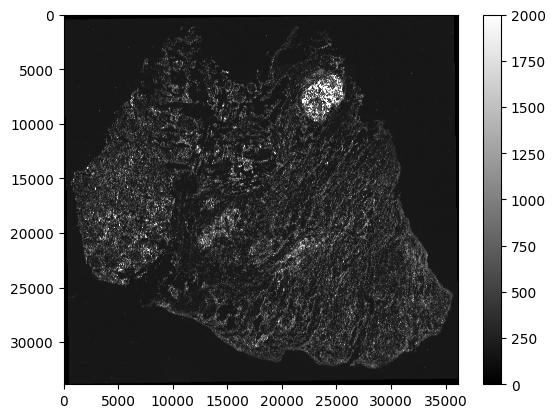

In [18]:
import dask.array as da
from dask_image.imread import imread as da_imread


image_dask_array = da_imread(image_dir)
image = image_dask_array[:5000, :, :].compute()

print(image.shape)

import matplotlib.pyplot as plt


# 使用matplotlib显示图像
plt.imshow(image[0], cmap='gray', vmax=2000)  # cmap参数设置颜色映射，'gray'表示灰度图
plt.colorbar()  # 可选，添加颜色条
plt.show()  # 显示图像

(33865, 36118)


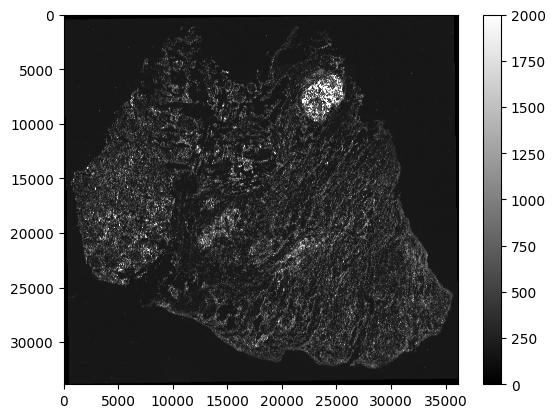

In [19]:
with tifffile.TiffFile(image_dir) as tif:
    # 获取第一个序列（series[0]），假设文件包含一个连续的三维数据集
    page = tif.pages[0]
    # 获取整个数据集的形状和数据类型
    shape = page.shape
    dtype = page.dtype
    # 位于文件的开始部分，
    # 实际上你可能需要根据TIFF文件的具体结构调整offset参数
    offset = page.dataoffsets[0]  # 数据在文件中的偏移量
    image_memmap = np.memmap(image_dir, dtype=dtype, mode='r', shape=shape)



# 创建内存映射数组
image_memmap = np.memmap(image_dir, dtype=dtype, mode='r', offset=offset, shape=shape)
image = image_memmap[:, :]
print(image.shape)


# 使用matplotlib显示图像
plt.imshow(image, cmap='gray', vmax=2000)  # cmap参数设置颜色映射，'gray'表示灰度图
plt.colorbar()  # 可选，添加颜色条
plt.show()  # 显示图像